# Multi-Gpu Equilibrium Solve

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [ ]:
num_device = 2
# from desc import set_device

# set_device("gpu", num_device=num_device)

In [3]:
from desc.examples import get
from desc.objectives import *
from desc.objectives.getters import *
from desc.grid import LinearGrid
from desc.backend import jnp
from desc.plotting import plot_grid

DESC version 0.13.0+1130.gc8481e158.dirty,using JAX backend, jax version=0.4.38, jaxlib version=0.4.38, dtype=float64
Using 2 devices:
	 Device 0: NVIDIA A100-PCIE-40GB (id=0) with 40.00 GB available memory
	 Device 1: NVIDIA A100-PCIE-40GB (id=1) with 40.00 GB available memory


In [4]:
eq = get("HELIOTRON")

In [5]:
obj = get_parallel_forcebalance(eq, num_device=num_device, check_device=False)
cons = get_fixed_boundary_constraints(eq)

Precomputing transforms
Precomputing transforms


In [6]:
print(obj.compute_scaled_error(obj.x()).shape)
print(obj.jac_scaled_error(obj.x()).shape)

(34632,)
(34632, 1977)


In [ ]:
eq.solve(objective=obj, constraints=cons, maxiter=2, ftol=0, gtol=0, xtol=0, verbose=3)

Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 1.99 sec
Timer: Linear constraint projection build = 5.61 sec
Number of parameters: 1593
Number of objectives: 34632
Timer: Initializing the optimization = 7.73 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.654e-07                                    1.803e-04   
       1              6          2.102e-07      1.552e-07      1.244e-03      5.327e-05   
       2              7          2.097e-07      5.059e-10      1.883e-03      6.156e-05   
         C

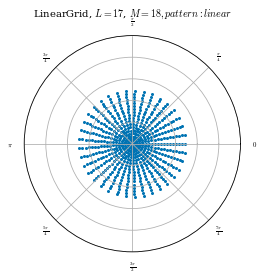

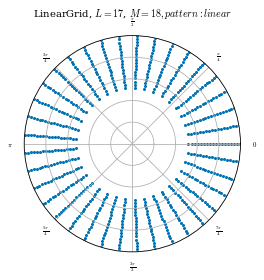

In [9]:
for obji in obj.objectives:
    plot_grid(obji.constants["transforms"]["grid"])